In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Add, AveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D, GlobalAveragePooling2D
import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label , regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import pandas as pd
import shutil
import time
from tensorflow.keras import layers
from sklearn.utils import shuffle
import scipy
import cv2
import imutils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from skimage import measure
from skimage.measure import label,regionprops
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16425096259235798248
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6924795904
locality {
  bus_id: 1
  links {
  }
}
incarnation: 971464328434783672
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
data_dir = r'C:/Shanta/data_image/3k_images'

filepaths = []
labels = []


for root, dirs, files in os.walk(data_dir):
    for klass in dirs:
        
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  # Make a combined dataframe

print(df['labels'].value_counts())

labels
Adrenocarcinoma            3000
Large_cell_carcinoma       3000
Normal                     3000
Small_cell_carcinoma       3000
Squamous_cell_carcinoma    3000
Name: count, dtype: int64


In [5]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [7]:
def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [8]:
def delete_table(slc):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < 0.3*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > 0.6*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [9]:
def keep_top_3(slc):
    new_slc = np.zeros_like(slc)
    rps = regionprops(slc)
    areas = [r.area for r in rps]
    idxs = np.argsort(areas)[::-1]
    for i in idxs[:3]:
        new_slc[tuple(rps[i].coords.T)] = i+1
    return new_slc

In [10]:
def remove_trachea(slc, c=0.0069):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0) 
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/512**2 < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [11]:
class_names = list(df['labels'].unique())
print(class_names)
num_classes = len(class_names)
image_size=(224,224)

['Adrenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Small_cell_carcinoma', 'Squamous_cell_carcinoma']


In [27]:
def load_data(path):
    datasets = [path]
    images = []
    classes_list = []

    # iterate through training and test sets
    count = 0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['Adrenocarcinoma']:
                classes = 0
            elif folder in ['Large_cell_carcinoma']:
                classes = 1
            elif folder in ['Normal']:
                classes = 2
            elif folder in ['Small_cell_carcinoma']:
                classes = 3
            elif folder in ['Squamous_cell_carcinoma']:
                classes = 4

            # iterate through each image in folder
            for file in tqdm.tqdm(os.listdir(os.path.join(dataset, folder))):
                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                mask = gray < 50
                mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)
                mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)
                slc = mask_labeled
                rps = regionprops(slc)
                areas = [r.area for r in rps]
                idxs = np.argsort(areas)[::-1]
                mask_labeled = np.vectorize(keep_top_3, signature='(n,m)->(n,m)')(mask_labeled)
                mask = mask_labeled > 0
                mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)
                mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)
                mask_new = np.vectorize(delete_table, signature='(n,m)->(n,m)')(mask)

                mask_new = binary_dilation(mask_new, iterations=5)

                img_new = mask_new * gray

                img_new= cv2.cvtColor(img_new, cv2.COLOR_GRAY2RGB)

                # resize th image
                image_new = cv2.resize(img_new, image_size)

                # Append the image and its corresponding label to the output
                images.append(image_new)
                classes_list.append(classes)

    images = np.array(images, dtype='float32')
    classes_list = np.array(classes_list, dtype='int32')

    return images, classes_list


In [28]:
images, classes_list = load_data(path='C:/Shanta/data_image/3k_images')

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [04:13<00:00, 11.82it/s]


In [29]:
classes_list.shape

(15000,)

In [30]:
train_images, mul_images, train_labels, mul_labels = train_test_split(images, classes_list, test_size = 0.2, stratify=classes_list, random_state = 42)
val_images, test_images, val_labels, test_labels = train_test_split(mul_images, mul_labels, test_size = 0.5, stratify=mul_labels, random_state=43)


In [31]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 12000
Number of validation examples: 1500
Number of testing examples: 1500
Training images are of shape: (12000, 224, 224, 3)
Training labels are of shape: (12000,)
Validation images are of shape: (1500, 224, 224, 3)
Validation labels are of shape: (1500,)
Test images are of shape: (1500, 224, 224, 3)
Test labels are of shape: (1500,)


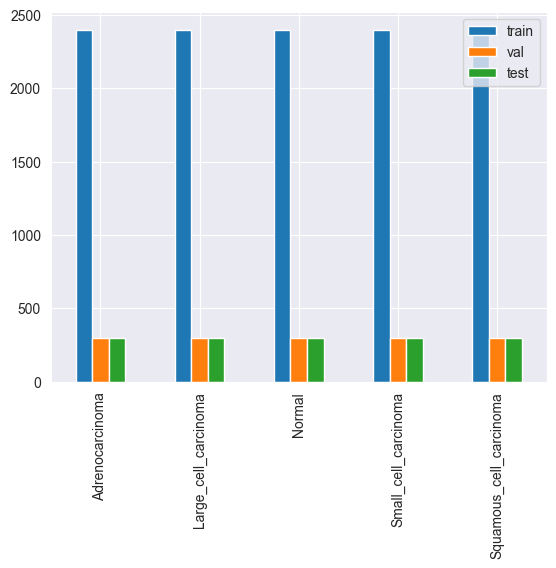

In [32]:

_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

In [33]:
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [34]:
train_labels

array([4, 0, 3, ..., 1, 1, 2])

In [35]:
test_labels

array([2, 2, 1, ..., 1, 0, 3])

In [36]:
train_images

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

12000


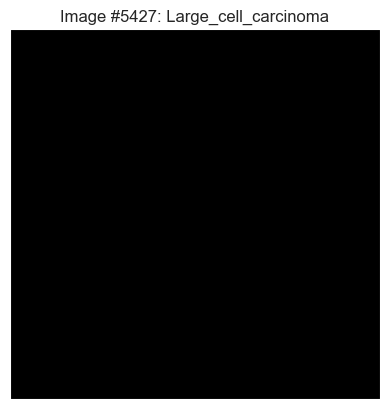

In [37]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

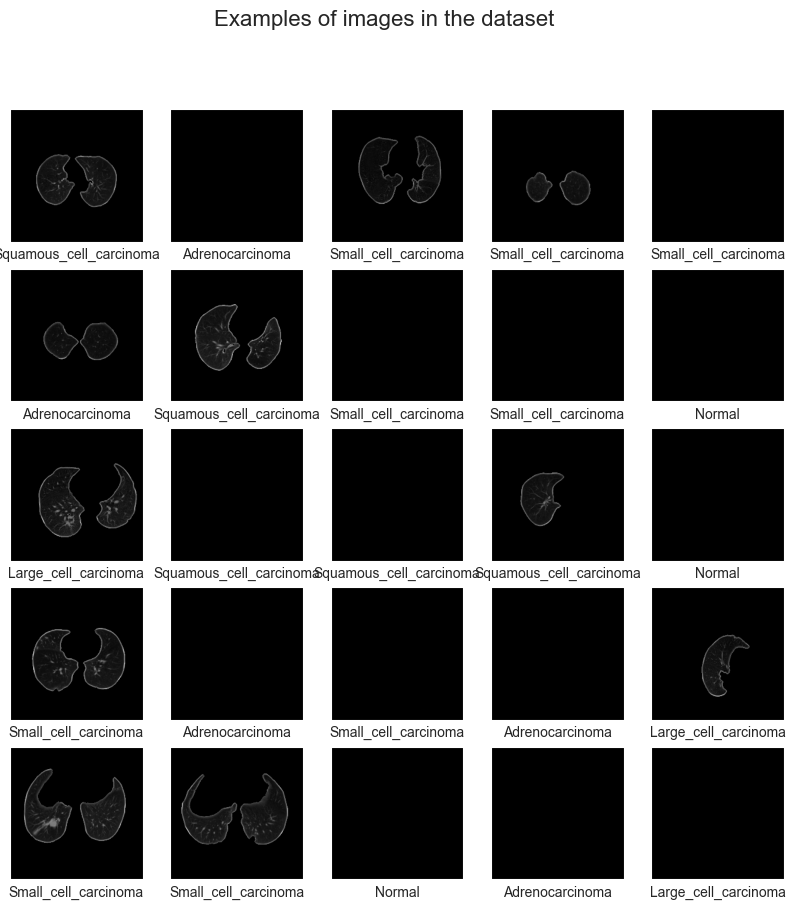

In [38]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [24]:
from tensorflow.keras.metrics import Recall, Precision, AUC, RootMeanSquaredError
from sklearn.metrics import f1_score

In [25]:
y_train = tf.keras.utils.to_categorical(train_labels, num_classes)
y_val = tf.keras.utils.to_categorical(val_labels, num_classes)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes)


In [26]:
datagen = ImageDataGenerator(featurewise_center=True,
            featurewise_std_normalization=True)

datagen.fit(train_images)
datagen.fit(val_images)
datagen.fit(test_images)
# Create data generators
train_generator = datagen.flow(train_images, y_train, batch_size=4)
val_generator = datagen.flow(val_images, y_val, batch_size=4)
test_generator = datagen.flow(test_images, y_test, batch_size=4)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (12000, 224, 224)

In [ ]:
from tensorflow.keras.applications import Xception, MobileNet, VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate

with tf.device('/device:GPU:0'):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    input_layer = Input(shape=(224, 224, 3))

    x = base_model(input_layer)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)

    predictions = Dense(5, activation='softmax')(x)

    # Create the final model
    model1 = Model(inputs=input_layer, outputs=predictions)
    model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'mse', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation', name='auc') ])
model1.summary()

# Implement callbacks
checkpoint = ModelCheckpoint(filepath='C:/Shanta/weights/mobilenet.h5', save_best_only=False, save_weights_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose=1, mode='min', restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)






Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328

In [ ]:
import time
start_time = time.time()
# Train
with tf.device('/device:GPU:0'):
    history1 = model1.fit(
        #train_images, y_train,
        train_generator,
        epochs=50,
        validation_data=val_generator,
        batch_size=4,
        callbacks=[learning_rate_reduction, checkpoint]
    )

end_time = time.time()

Epoch 1/50
3000/3000 [==============================] - 76s 16ms/step - loss: 0.6783 - accuracy: 0.7132 - mse: 0.0733 - recall: 0.6154 - auc: 0.9399 - val_loss: 0.6966 - val_accuracy: 0.7647 - val_mse: 0.0721 - val_recall: 0.7447 - val_auc: 0.9514 - lr: 0.0010
Epoch 2/50
3000/3000 [==============================] - 46s 15ms/step - loss: 0.3658 - accuracy: 0.8604 - mse: 0.0392 - recall: 0.8309 - auc: 0.9824 - val_loss: 0.3564 - val_accuracy: 0.8647 - val_mse: 0.0384 - val_recall: 0.8507 - val_auc: 0.9835 - lr: 0.0010
Epoch 3/50
3000/3000 [==============================] - 46s 15ms/step - loss: 0.2261 - accuracy: 0.9203 - mse: 0.0241 - recall: 0.9081 - auc: 0.9922 - val_loss: 0.4419 - val_accuracy: 0.8507 - val_mse: 0.0442 - val_recall: 0.8440 - val_auc: 0.9792 - lr: 0.0010
Epoch 4/50
3000/3000 [==============================] - 47s 16ms/step - loss: 0.1770 - accuracy: 0.9397 - mse: 0.0180 - recall: 0.9333 - auc: 0.9949 - val_loss: 0.2869 - val_accuracy: 0.8993 - val_mse: 0.0291 - val_re

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
# Evaluate on the test set using the test generator
test_results = model1.evaluate(test_generator, steps=len(test_images) // 4)  # Assuming batch_size=4 for the test generator

print("Loss of the model on test set is:", test_results[0])
print("Accuracy of the model on test set is:", test_results[1] * 100, "%")
print(test_results)

# Evaluate on the validation set using the validation generator
val_results = model1.evaluate(val_generator, steps=len(val_images) // 4)  # Assuming batch_size=4 for the validation generator

print("Loss of the model on validation set is:", val_results[0])
print("Accuracy of the model on validation set is:", val_results[1] * 100, "%")
print(val_results)

375/375 [==============================] - 5s 13ms/step - loss: 0.1088 - accuracy: 0.9867 - mse: 0.0045 - recall: 0.9867 - auc: 0.9958
Loss of the model on test set is: 0.10882604867219925
Accuracy of the model on test set is: 98.66666793823242 %
[0.10882604867219925, 0.9866666793823242, 0.004461518954485655, 0.9866666793823242, 0.9958449006080627]
375/375 [==============================] - 5s 13ms/step - loss: 0.0869 - accuracy: 0.9840 - mse: 0.0049 - recall: 0.9840 - auc: 0.9966
Loss of the model on validation set is: 0.08694469183683395
Accuracy of the model on validation set is: 98.4000027179718 %
[0.08694469183683395, 0.984000027179718, 0.00491110747680068, 0.984000027179718, 0.9965657591819763]


In [ ]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = getattr(test_gen, 'class_indices', None)

    new_dict = {}
    if class_dict:
        for key, value in class_dict.items():
            new_dict[value] = key  # dictionary {integer of class number: string of class name}

        # store new_dict as a text file in the save_dir
        classes = list(new_dict.values())  # list of string of class names
        dict_as_text = str(new_dict)
        dict_name = subject + '-' + str(len(classes)) + '.txt'
        dict_path = os.path.join(save_dir, dict_name)
        with open(dict_path, 'w') as x_file:
            x_file.write(dict_as_text)

    errors = 0
    y_pred = []

    if class_dict:
        for i, p in enumerate(preds):
            pred_index = np.argmax(p)
            y_pred.append(pred_index)
    else:
        y_pred = np.argmax(preds, axis=1)

    if print_code != 0:
        msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
        print(msg)

    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items() if class_dict else enumerate(set(y_pred)):
            count = y_pred.tolist().count(key) if class_dict else y_pred.tolist().count(value)
            if count != 0:
                plot_bar.append(count)  # list containing how many times a class c had an error
                plot_class.append(value)  # stores the class

        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
            plt.title(' Errors by Class on Test Set')

    if class_dict and len(classes) <= 30:
        # create a confusion matrix
        cm = confusion_matrix(test_gen.classes, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(test_gen.classes, y_pred, target_names=classes if class_dict else None)
    print("Classification Report:\n----------------------\n", clr)

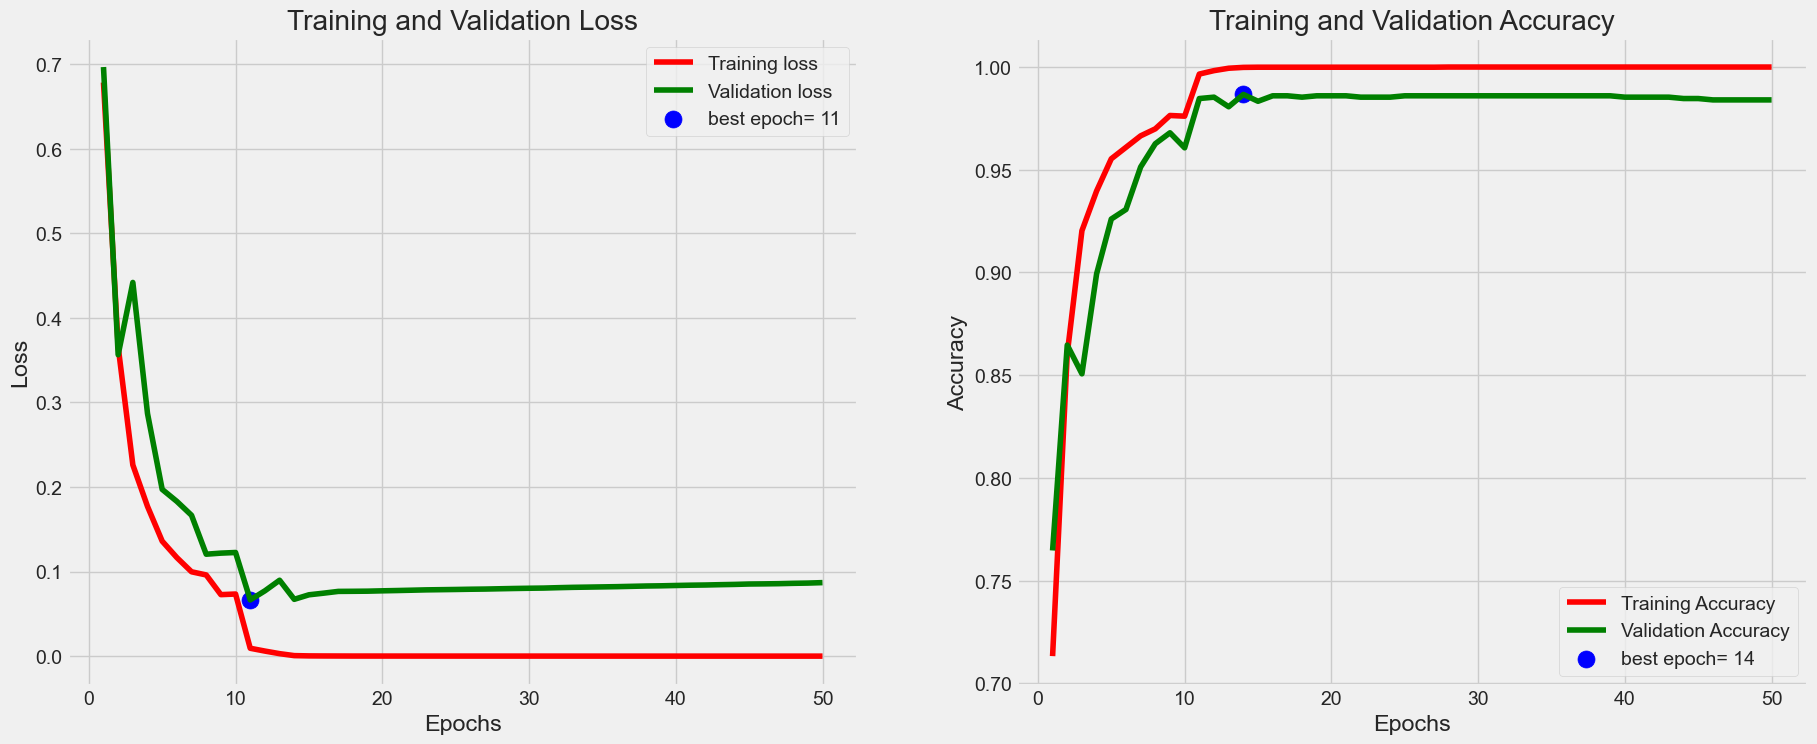

375/375 [==============================] - 5s 13ms/step - loss: 0.1088 - accuracy: 0.9867 - mse: 0.0045 - recall: 0.9867 - auc: 0.9958
accuracy on the test set is 98.67 %



In [ ]:
tr_plot(history1,0)
save_dir=r'C:/Shanta/model/'
subject='lung cancer'
acc=model1.evaluate( test_generator, batch_size=4, verbose=1, steps=len(test_generator), return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str ('mobilenet' +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model1.save(save_loc)

In [ ]:
model1.save('C:/Shanta/weights/mobilenet.hdf5')

In [ ]:


model_weight = tf.keras.models.load_model('C:/Shanta/weights/mobilenet.hdf5')

In [ ]:
## Ekhane code kichu change hobe last e bujhli
## ekhane ekta error ashe ami dekhi resolve korte pari kina


375/375 [==============================] - 3s 9ms/step


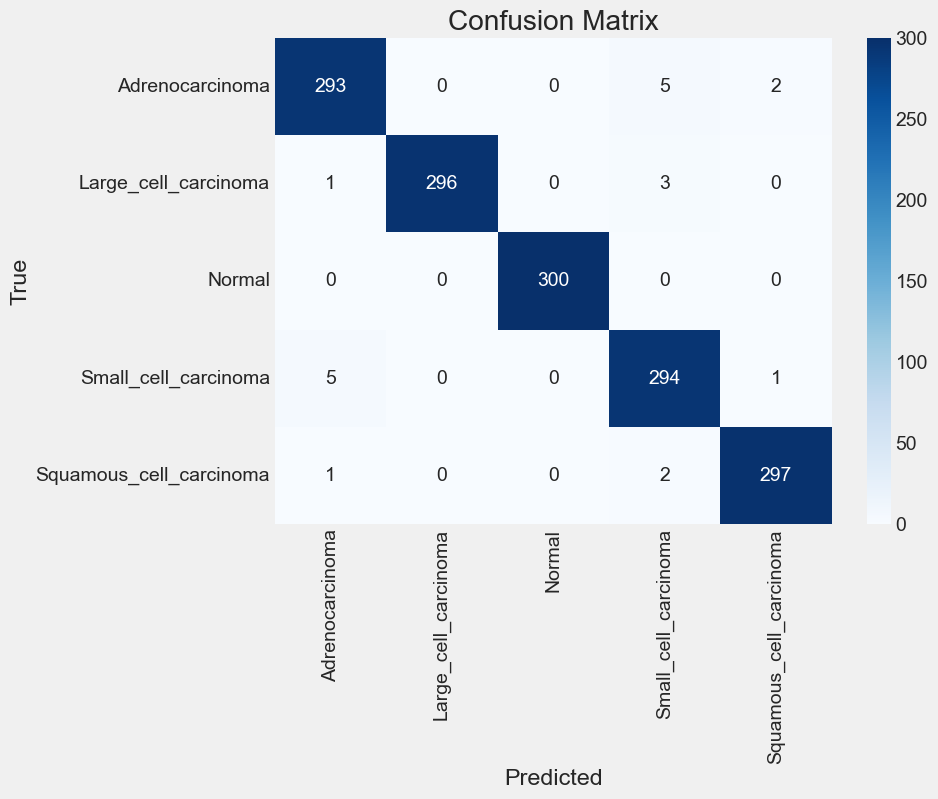

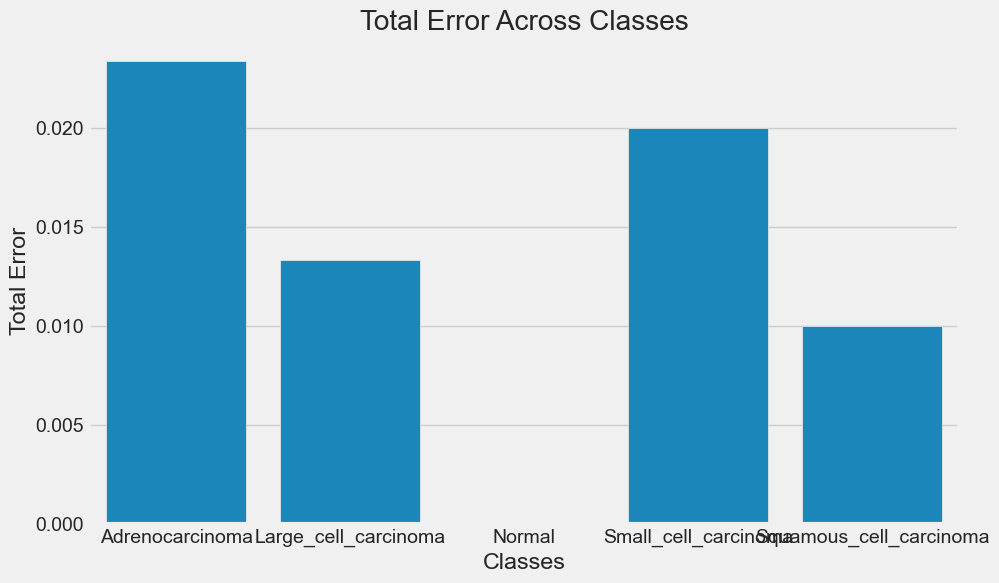

In [ ]:
true_labels = np.argmax(y_test, axis=1)  
test_generator_no_shuffle = datagen.flow(test_images, y_test, batch_size=4, shuffle=False)

predicted_labels = np.argmax(model_weight.predict(test_generator_no_shuffle), axis=1)


conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Adrenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Small_cell_carcinoma', 'Squamous_cell_carcinoma'], yticklabels=['Adrenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Small_cell_carcinoma', 'Squamous_cell_carcinoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate total error for each class
error_per_class = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Plot bar plot for total error across classes
plt.figure(figsize=(10, 6))
sns.barplot(x=['Adrenocarcinoma', 'Large_cell_carcinoma', 'Normal', 'Small_cell_carcinoma', 'Squamous_cell_carcinoma'], y=error_per_class)
plt.xlabel('Classes')
plt.ylabel('Total Error')
plt.title('Total Error Across Classes')
plt.show()

In [ ]:
results = model_weight.evaluate(test_generator_no_shuffle)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")

375/375 [==============================] - 5s 13ms/step - loss: 0.1088 - accuracy: 0.9867 - mse: 0.0045 - recall: 0.9867 - auc: 0.9958
Loss of the model  is - test  0.10882604867219925
Accuracy of the model is - test 98.66666793823242 %
